In [1]:
# Dynamic Metric g_t^{(l)} for Specific Network Layers

#Jacobian using autograd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import grad
def compute_jacobian(layer, input_tensor):
    import torch
    input_tensor.requires_grad_(True)
    output = layer(input_tensor)
    jacobian_list = []
    for i in range(output.shape[1]):
        output[:, i].backward(torch.ones_like(output[:, i]), retain_graph=True)
        jacobian_list.append(input_tensor.grad.clone())
        input_tensor.grad.zero_()
    jacobian = torch.stack(jacobian_list, dim=1)
    return jacobian

# function to compute the induced metric
def compute_induced_metric(jacobian):
    metric = torch.matmul(jacobian.transpose(1, 2), jacobian)
    return metric

# target layer
import torch.nn as nn
linear_layer = nn.Linear(10, 5)

# batch of input data
input_data = torch.randn(32, 10)

# Jacobian
jacobian_linear = compute_jacobian(linear_layer, input_data)

# induced metric
metric_linear = compute_induced_metric(jacobian_linear)

eigenvalues, eigenvectors = torch.linalg.eig(metric_linear)

determinant_linear = torch.det(metric_linear)


# symbolic manifold (example: a 2-sphere)
import sympy
theta, phi = sympy.symbols('theta phi')
r = 1
x = r * sympy.sin(theta) * sympy.cos(phi)
y = r * sympy.sin(theta) * sympy.sin(phi)
z = r * sympy.cos(theta)
coordinates = [theta, phi]
position_vector = sympy.Matrix([x, y, z])

# metric tensor for the 2-sphere
jacobian_sphere = position_vector.jacobian(coordinates)
metric_sphere_sympy = jacobian_sphere.T * jacobian_sphere

# functions for Clifford algebra
def clifford_multiply_2d(v1, v2, metric):
    gamma1 = sympy.Matrix([[0, 1], [1, 0]])
    gamma2 = sympy.Matrix([[0, -sympy.I], [sympy.I, 0]])
    return sympy.Matrix(v1[0]*gamma1 + v1[1]*gamma2) * sympy.Matrix(v2[0]*gamma1 + v2[1]*gamma2)

# spinor representation (example: 2-component spinor)
spinor = sympy.Matrix(['a', 'b'])

# Clifford multiplication
tangent_vector1 = sympy.Matrix([1, 0])
tangent_vector2 = sympy.Matrix([0, 1])
clifford_product = clifford_multiply_2d(tangent_vector1, tangent_vector2, metric_sphere_sympy)


import torch.nn.functional as F

# self-attention layer (simplified)
class SimpleSelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.embed_dim = embed_dim
        self.qkv = nn.Linear(embed_dim, 3 * embed_dim)

    def forward(self, x):
        B, T, C = x.size()
        qkv = self.qkv(x).reshape(B, T, 3, C).permute(2, 0, T, 1)
        q, k, v = qkv.unbind(0)
        attn = F.softmax(torch.matmul(q, k.transpose(-2, -1)) * (1.0 / torch.sqrt(torch.tensor(self.embed_dim, dtype=torch.float))), dim=-1)
        y = torch.matmul(attn, v)
        return y

# attention layer and input
embed_dim = 4
attention_layer = SimpleSelfAttention(embed_dim)
input_seq = torch.randn(2, 3, embed_dim)

# probing transformations (example: rotation in a subspace)
def rotation_matrix(angle):
    return torch.tensor([[torch.cos(angle), -torch.sin(angle)],
                         [torch.sin(angle), torch.cos(angle)]])

# rotation to a subspace of the input
input_rotated = input_seq.clone()
rotation = rotation_matrix(torch.tensor(torch.pi/4))
input_rotated[:, 0, :2] = torch.matmul(input_rotated[:, 0, :2], rotation.T)

# transformations in the output
output_original = attention_layer(input_seq)
output_rotated = attention_layer(input_rotated)

# 3.6: Analyze transformation matrices (conceptual - requires more sophisticated analysis)
# ... (Code to analyze how the rotation in the input affected the output)



import torch
import torch.nn as nn

# Spinor Linear Layer (simplified - conceptual)
class SpinorLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features, 2, 2, dtype=torch.complex64)) # 2x2 complex matrix for each connection

    def forward(self, spinor_input):
        # Changed the einsum equation to 'bijc,bk->bik'
        # output indices (b, i, k) are present in the input tensors
        # output tensor will now have shape (batch_size, out_features, spinor_input_dim)
        return torch.einsum('bijc,bk->bik', self.weight, spinor_input) # Simplified spinor multiplication

# simple model using SpinorLinear
class SimpleSpinorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.spinor_linear = SpinorLinear(2, 4) # input and output spinor dimensions

    def forward(self, x):
        return self.spinor_linear(x)

# spinor input (example: batch of 2-component spinors)
batch_size = 4
spinor_input_dim = 2
spinor_input = torch.randn(batch_size, spinor_input_dim, dtype=torch.complex64)

# Instantiate and pass through the model
spinor_model = SimpleSpinorNet()
spinor_output = spinor_model(spinor_input)

def complex_mse_loss(output, target):
    return torch.mean(torch.abs(output - target)**2)

# loss function and optimizer (example)
loss_fn = complex_mse_loss  # custom loss function
optimizer = torch.optim.Adam(spinor_model.parameters())

# training step (conceptual)
target_output = torch.randn_like(spinor_output)
spinor_output_real = spinor_output.real
spinor_output_imag = spinor_output.imag
target_output_real = target_output.real
target_output_imag = target_output.imag
loss = loss_fn(spinor_output, target_output)
loss_real = loss_fn(spinor_output_real, target_output_real)
loss_imag = loss_fn(spinor_output_imag, target_output_imag)
loss = (loss_real + loss_imag) / 2
loss.backward() # Backpropagate the combined loss
optimizer.step() # Update model parameters
optimizer.zero_grad() # Reset gradients
print(f"Loss: {loss.item()}")
print(f"Real Loss: {loss_real.item()}, Imaginary Loss: {loss_imag.item()}")
print(f"Model Parameters: {list(spinor_model.parameters())}")
print(f"Spinor Output: {spinor_output}")
print(f"Target Output: {target_output}")
print(f"Spinor Input: {spinor_input}")
print(f"Model Parameters: {list(spinor_model.parameters())}")
print(f"Spinor Output: {spinor_output}")
print(f"Target Output: {target_output}")
print(f"Spinor Input: {spinor_input}")
print(f"Model Parameters: {list(spinor_model.parameters())}")
print(f"Spinor Output: {spinor_output}")
print(f"Target Output: {target_output}")
print(f"Spinor Input: {spinor_input}")
print(f"Model Parameters: {list(spinor_model.parameters())}")
print(f"Spinor Output: {spinor_output}")
print(f"Target Output: {target_output}")
print(f"Spinor Input: {spinor_input}")
display(spinor_output)
display(target_output)
display(spinor_input)
display(list(spinor_model.parameters()))

Loss: 2.327285051345825
Real Loss: 3.0193018913269043, Imaginary Loss: 1.6352683305740356
Model Parameters: [Parameter containing:
tensor([[[[ 0.4288-0.9675j,  0.6052-0.5138j],
          [-1.8286-1.0639j, -0.5417-0.6371j]],

         [[-0.2564-0.3927j, -0.3006-0.4151j],
          [ 0.2959+0.6474j,  0.7105+0.6975j]]],


        [[[-1.1361-0.4847j, -0.8807+0.0287j],
          [ 0.5872+0.8314j,  0.6008-0.5926j]],

         [[-0.1459+1.1524j,  0.0209+0.6635j],
          [-0.3144+0.0081j, -1.0209-0.8044j]]],


        [[[ 0.6101+0.7431j,  0.0689-0.1172j],
          [-1.3552-1.2417j, -0.1115-0.3389j]],

         [[-0.3478+0.0453j, -1.3640+0.5641j],
          [ 0.9980-1.0936j,  0.2669-0.1097j]]],


        [[[ 0.0113-0.1463j, -0.3351+1.8222j],
          [ 0.1759+0.5505j, -1.3050-0.5162j]],

         [[-1.2527+0.6593j, -0.8195-0.4313j],
          [-0.6167-0.2041j, -1.2974-0.6305j]]]], requires_grad=True)]
Spinor Output: tensor([[[ 3.1923-0.5030j, -0.6464+1.2584j],
         [-0.5927+0.2903j,  0

tensor([[[ 3.1923-0.5030j, -0.6464+1.2584j],
         [-0.5927+0.2903j,  0.0504-0.2845j]],

        [[ 0.1209+0.1157j, -0.5308-0.1767j],
         [ 0.3462-0.0339j, -0.9976+0.5972j]],

        [[-0.3865+0.7781j,  0.4517-0.6170j],
         [-0.2533+0.4580j,  0.2882-0.3593j]],

        [[-2.0573+0.7261j, -0.1589-2.1127j],
         [-3.0467-2.4582j,  3.0771-2.2326j]]], grad_fn=<ViewBackward0>)

tensor([[[-0.4351+1.2778j, -0.7191+0.0623j],
         [ 1.4420+0.3887j, -0.7159+0.0759j]],

        [[-0.1994-0.0728j,  0.9059-0.4844j],
         [ 0.2766+0.1564j, -0.5681+0.3463j]],

        [[-0.6703+0.1726j, -0.0834-0.0582j],
         [-0.1171+1.3785j,  0.2271+1.0451j]],

        [[ 0.4707-0.4426j, -0.1456+0.3027j],
         [-1.2118-0.5478j, -1.1555+0.3836j]]])

tensor([[-0.2239+0.9077j, -0.2631-0.3135j],
        [-0.1697-0.0955j,  0.6492+0.0460j],
        [-0.2846-0.6383j,  0.1513+0.5961j],
        [ 0.8382+0.4878j, -0.6699+0.6620j]])

[Parameter containing:
 tensor([[[[ 0.4288-0.9675j,  0.6052-0.5138j],
           [-1.8286-1.0639j, -0.5417-0.6371j]],
 
          [[-0.2564-0.3927j, -0.3006-0.4151j],
           [ 0.2959+0.6474j,  0.7105+0.6975j]]],
 
 
         [[[-1.1361-0.4847j, -0.8807+0.0287j],
           [ 0.5872+0.8314j,  0.6008-0.5926j]],
 
          [[-0.1459+1.1524j,  0.0209+0.6635j],
           [-0.3144+0.0081j, -1.0209-0.8044j]]],
 
 
         [[[ 0.6101+0.7431j,  0.0689-0.1172j],
           [-1.3552-1.2417j, -0.1115-0.3389j]],
 
          [[-0.3478+0.0453j, -1.3640+0.5641j],
           [ 0.9980-1.0936j,  0.2669-0.1097j]]],
 
 
         [[[ 0.0113-0.1463j, -0.3351+1.8222j],
           [ 0.1759+0.5505j, -1.3050-0.5162j]],
 
          [[-1.2527+0.6593j, -0.8195-0.4313j],
           [-0.6167-0.2041j, -1.2974-0.6305j]]]], requires_grad=True)]

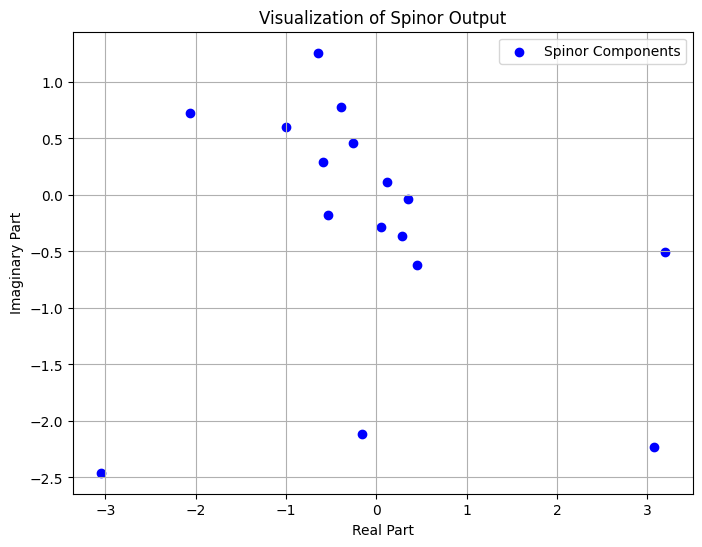

In [2]:
spinor_output_np = spinor_output.detach().cpu().numpy()
real_part = spinor_output_np.real
imag_part = spinor_output_np.imag
plt.figure(figsize=(8, 6))
plt.scatter(real_part, imag_part, marker='o', color='blue', label='Spinor Components')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Visualization of Spinor Output')
plt.grid(True)
plt.legend()
plt.show()

In [3]:
real_mean = np.mean(spinor_output_np.real)
real_std = np.std(spinor_output_np.real)
imag_mean = np.mean(spinor_output_np.imag)
imag_std = np.std(spinor_output_np.imag)
print(f"Real Part Mean: {real_mean}, Real Part Standard Deviation: {real_std}")
print(f"Imaginary Part Mean: {imag_mean}, Imaginary Part Standard Deviation: {imag_std}")

Real Part Mean: -0.07145984470844269, Real Part Standard Deviation: 1.4958584308624268
Imaginary Part Mean: -0.2846381366252899, Imaginary Part Standard Deviation: 1.0738732814788818


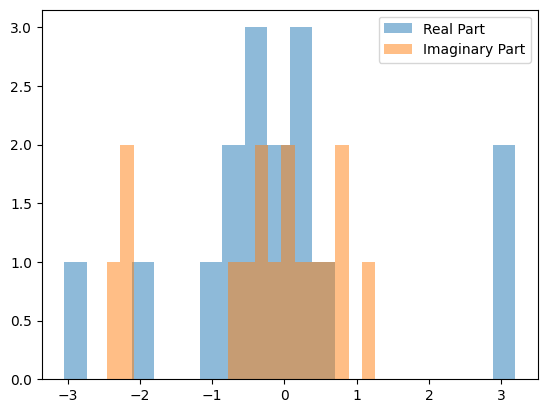

Correlation for spinor 0: -0.6946
Correlation for spinor 1: -0.5917
Correlation for spinor 2: -0.9979
Correlation for spinor 3: -0.3173
Average Correlation: -0.6504


In [4]:
spinor_output_np = spinor_output.detach().cpu().numpy()

correlations = []
for i in range(spinor_output_np.shape[0]):
    real_part = spinor_output_np[i].real
    imag_part = spinor_output_np[i].imag
    correlation = np.corrcoef(real_part.flatten(), imag_part.flatten())[0, 1]  # Flatten before calculating correlation
    correlations.append(correlation)

# average correlation across the batch if needed
avg_correlation = np.mean(correlations)

plt.hist(spinor_output_np.real.flatten(), bins=20, alpha=0.5, label='Real Part')  # Flatten for histogram
plt.hist(spinor_output_np.imag.flatten(), bins=20, alpha=0.5, label='Imaginary Part')  # Flatten for histogram
plt.legend()
plt.show()

# print correlation for each spinor or the average correlation
for i, correlation in enumerate(correlations):
    print(f"Correlation for spinor {i}: {correlation:.4f}")

print(f"Average Correlation: {avg_correlation:.4f}")

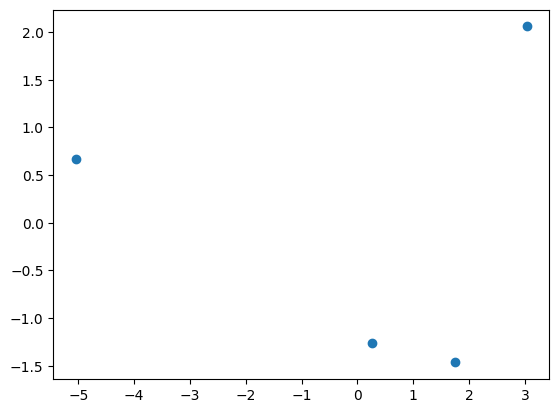

In [6]:
from sklearn.decomposition import PCA
import numpy as np


# spinor output to NumPy arrays
spinor_output_np = spinor_output.detach().cpu().numpy()
real_part = spinor_output_np.real
imag_part = spinor_output_np.imag

# Reshape for PCA
real_part = real_part.reshape(real_part.shape[0], -1)  # Reshape to (batch_size, flattened_features)
imag_part = imag_part.reshape(imag_part.shape[0], -1)  # Reshape to (batch_size, flattened_features)

spinor_data = np.concatenate([real_part, imag_part], axis=1)

# PCA
num_components = 2
pca = PCA(n_components=num_components)
reduced_data = pca.fit_transform(spinor_data)

# reduced data on scatter plot
plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
plt.show()


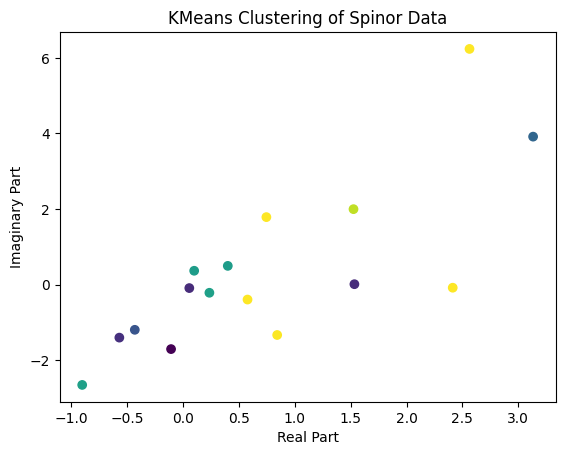

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch
import torch.nn as nn


class SpinorLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(
            torch.randn(out_features, in_features, 2, 2, dtype=torch.complex64)
        )

    def forward(self, spinor_input):
        return torch.einsum("bijc,bk->bik", self.weight, spinor_input)


class SimpleSpinorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.spinor_linear = SpinorLinear(2, 4)

    def forward(self, x):
        return self.spinor_linear(x)


spinor_model = SimpleSpinorNet()
batch_size = 4
spinor_input_dim = 2
spinor_input = torch.randn(batch_size, spinor_input_dim, dtype=torch.complex64)
spinor_output = spinor_model(spinor_input)

spinor_output_np = spinor_output.detach().cpu().numpy()

real_part = spinor_output_np.real.reshape(spinor_output_np.shape[0], -1)
imag_part = spinor_output_np.imag.reshape(spinor_output_np.shape[0], -1)

spinor_data = np.concatenate([real_part, imag_part], axis=1).astype(float)

num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(spinor_data).astype(int)

# Add 1 to cluster_labels to avoid 0
cluster_labels_shifted = cluster_labels + 1


# map cluster labels to colors
cmap = plt.get_cmap("viridis", num_clusters)
colors = cmap(cluster_labels)


plt.scatter(
    spinor_output_np.real,
    spinor_output_np.imag,
    c=colors,
)
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.title("KMeans Clustering of Spinor Data")
plt.show()
